<a href="https://colab.research.google.com/github/kanishkjain1995/Face-Recognition/blob/master/Face_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import tensorflow as tf
from google.colab import files, drive
import os
import matplotlib.pyplot as plt
import cv2
import numpy as np

In [4]:
drive.mount('/content/gdrive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
!mkdir lfw_mtcnnpy_160

In [0]:
!tar -xf gdrive/My\ Drive/lfw_mtcnnpy_160.tgz lfw_mtcnnpy_160

In [0]:
dataset_path = "lfw_mtcnnpy_160"

In [8]:
dim = (64, 64)
faces = []
names = []
index = 0
for name in os.listdir(dataset_path):
    image_file_path = os.path.join(dataset_path, name)
    if os.path.isfile(image_file_path):
        continue
    if len(os.listdir(image_file_path)) <= 2:
        continue
    for image_file in os.listdir(image_file_path):
        image_path = os.path.join(image_file_path, image_file)
        if image_file[0]==".":
            break
        image = cv2.imread(image_path)
        image = cv2.resize(image, dim)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        faces.append(image)
        names.append(name)
    index+=1

faces = np.stack(faces)/255.0
names = np.stack(names)
print(faces.shape, names.shape)
print(names)

(7599, 64, 64, 3) (7599,)
['Bob_Stoops' 'Bob_Stoops' 'Bob_Stoops' ... 'Paul_Tagliabue'
 'Paul_Tagliabue' 'Paul_Tagliabue']


Kim_Ryong-sung


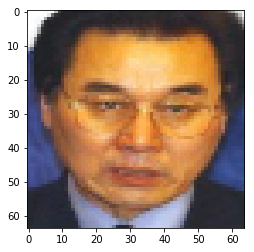

In [9]:
ind = np.random.choice(range(faces.shape[0]), 1)[0]
plt.imshow(faces[ind])
print(names[ind])

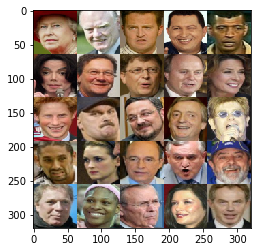

In [10]:
indexes = np.random.choice(range(len(faces)), 5)
img = np.vstack([np.hstack([faces[ind] for ind in np.random.choice(range(len(faces)), 5)]) for i in range(5)])
plt.imshow(img)
plt.show()

In [0]:
unique, count = np.unique(names, return_counts=True)
ind = np.where(count > 1)[0]
left_faces = []
right_faces = []
labels = []
for name in unique[ind]:
    indx = np.where(names == name)[0]
    n_indx = np.where(names != name)[0]
    for i in range(len(indx)):
        index = np.random.choice(indx, 2, replace=False)
        left_faces.append(faces[index][0])
        right_faces.append(faces[index][1])
        labels.append(1)
    for i in range(len(indx)):
        n_index = [np.random.choice(n_indx, 1, replace=False)[0], np.random.choice(indx, 1, replace=False)[0]]
        left_faces.append(faces[n_index][0])
        right_faces.append(faces[n_index][1])
        labels.append(0)

left_faces = np.stack(left_faces)
right_faces = np.stack(right_faces)
labels = np.stack(labels)

In [12]:
del faces
del names
print(len(left_faces))

15196


In [0]:
input_shape = (64, 64, 3)

In [16]:
vgg = tf.keras.applications.VGG16(include_top=False, weights='imagenet', input_shape=input_shape)
vgg.summary()

W0801 15:40:33.041066 140292501956480 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


58892288/58889256 [==============================] - 1s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
______________________________________________________________

In [17]:
model = tf.keras.models.Sequential([
    vgg,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dense(512, activation='sigmoid')
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 2, 2, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              2098176   
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800    
Total params: 17,337,664
Trainable params: 17,337,664
Non-trainable params: 0
_________________________________________________________________


In [0]:
left_input = tf.keras.Input(input_shape)
right_input = tf.keras.Input(input_shape)

encoded_l = model(left_input)
encoded_r = model(right_input)

l1_layer = tf.keras.layers.Lambda(lambda tensors: tf.abs(tensors[0] - tensors[1]))
similarity = l1_layer([encoded_l, encoded_r])
    
prediction = tf.keras.layers.Dense(1,activation='sigmoid', kernel_regularizer=tf.keras.regularizers.l2(1e-2))(similarity)

siamese_net = tf.keras.Model(inputs=[left_input,right_input], outputs=prediction)

In [19]:
optimizer = tf.train.AdamOptimizer(1e-6)
siamese_net.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=['accuracy'])

W0801 15:40:37.763218 140292501956480 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [21]:
history = siamese_net.fit(x=[left_faces, right_faces], y=labels, batch_size=512, epochs=60, validation_split=0.1, shuffle=True)

Train on 13676 samples, validate on 1520 samples
Epoch 1/60
13676/13676 [==============================] - 84s 6ms/sample - loss: 0.7112 - acc: 0.5172 - val_loss: 0.7117 - val_acc: 0.5099
Epoch 2/60
13676/13676 [==============================] - 59s 4ms/sample - loss: 0.7078 - acc: 0.5513 - val_loss: 0.7099 - val_acc: 0.5276
Epoch 3/60
13676/13676 [==============================] - 59s 4ms/sample - loss: 0.7046 - acc: 0.5732 - val_loss: 0.7080 - val_acc: 0.5349
Epoch 4/60
13676/13676 [==============================] - 59s 4ms/sample - loss: 0.7010 - acc: 0.5852 - val_loss: 0.7057 - val_acc: 0.5428
Epoch 5/60
13676/13676 [==============================] - 59s 4ms/sample - loss: 0.6966 - acc: 0.5909 - val_loss: 0.7024 - val_acc: 0.5441
Epoch 6/60
13676/13676 [==============================] - 59s 4ms/sample - loss: 0.6909 - acc: 0.5886 - val_loss: 0.6980 - val_acc: 0.5408
Epoch 7/60
13676/13676 [==============================] - 59s 4ms/sample - loss: 0.6838 - acc: 0.5885 - val_loss: 0.6

Text(0.5, 1.0, 'acc')

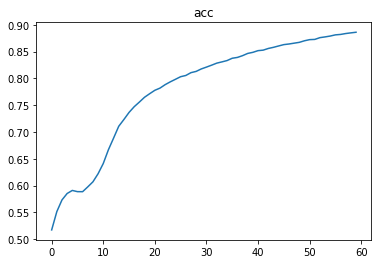

In [22]:
plt.plot(history.history['acc'])
plt.title("acc")

Text(0.5, 1.0, 'val_acc')

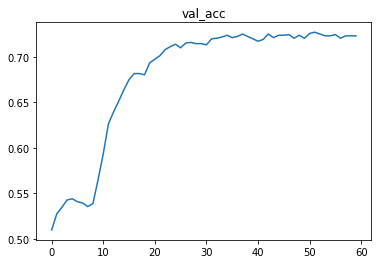

In [23]:
plt.plot(history.history['val_acc'])
plt.title("val_acc")

Text(0.5, 1.0, 'loss')

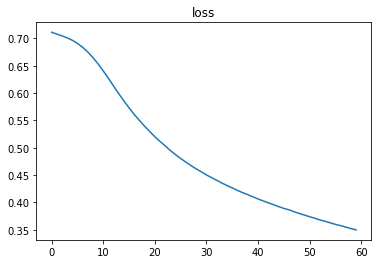

In [24]:
plt.plot(history.history['loss'])
plt.title("loss")

Text(0.5, 1.0, 'val_loss')

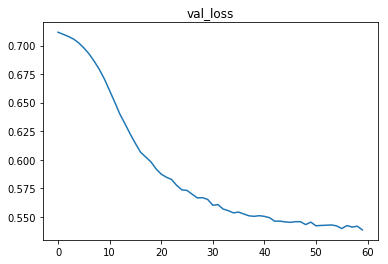

In [25]:
plt.plot(history.history['val_loss'])
plt.title("val_loss")